In [27]:
import pandas as pd
import glob

files = sorted(glob.glob('run_ca*.csv'))
df = pd.concat((pd.read_csv(f) for f in files), ignore_index=True)

print(f"Loaded {len(files)} files, total rows = {len(df)}")
df.head()


Loaded 2 files, total rows = 4400


,run_id,episode_index,step_count,time_start,time_end,time_delta_ms,observation_state,action_taken,reward_received,terminated,bits_per_value,row_length,neighborhood_radius,num_ca_ticks,boundary_condition,action_decoding,rule_index
0,20250519_094326,0,0,646890.841583,646890.842638,1.0548,[-0.01467501 -0.0154378 0.03585014 -0.02343547],0,1.0,False,8,64,1,10,NaN,center,"[1, 1, 0, 1, 1, 1, 1, 0]"
1,20250519_094326,0,1,646890.862596,646890.863642,1.0456,[-0.01498376 -0.21105506 0.03538144 0.28033954],1,1.0,False,8,64,1,10,NaN,center,"[1, 1, 0, 1, 1, 1, 1, 0]"
2,20250519_094326,0,2,646890.883123,646890.884259,1.1361,[-0.01920486 -0.0164552 0.04098823 -0.00097757],0,1.0,False,8,64,1,10,NaN,center,"[1, 1, 0, 1, 1, 1, 1, 0]"
3,20250519_094326,0,3,646890.903217,646890.904472,1.2551,[-0.01953397 -0.21214029 0.04096868 0.30435067],1,1.0,False,8,64,1,10,NaN,center,"[1, 1, 0, 1, 1, 1, 1, 0]"
4,20250519_094326,0,4,646890.923741,646890.925027,1.2863,[-0.02377677 -0.0176254 0.04705569 0.02486461],1,1.0,False,8,64,1,10,NaN,center,"[1, 1, 0, 1, 1, 1, 1, 0]"


In [28]:
# 2) Compute per-episode metrics
episode_stats = []
for (_, rad, ep), grp in df.groupby(['run_id', 'neighborhood_radius', 'episode_index']):
    steps = len(grp)
    mean_time = grp['time_delta_ms'].mean()
    actions = grp.sort_values('step_count')['action_taken'].tolist()
    if len(actions)>1:
        switches = sum(1 for i in range(1,len(actions)) if actions[i]!=actions[i-1])
        switch_rate = switches/(len(actions)-1)
    else:
        switch_rate = 0.0

    episode_stats.append({
        'radius':      rad,
        'steps':       steps,
        'time_ms':     mean_time,
        'switch_rate': switch_rate
    })

eps_df = pd.DataFrame(episode_stats)

# 3) Aggregate by neighborhood radius
summary = eps_df.groupby('radius').agg(
    mean_steps   = ('steps',       'mean'),
    std_steps    = ('steps',       'std'),
    mean_time    = ('time_ms',     'mean'),
    std_time     = ('time_ms',     'std'),
    mean_switch  = ('switch_rate', 'mean'),
    std_switch   = ('switch_rate', 'std')
).reset_index()


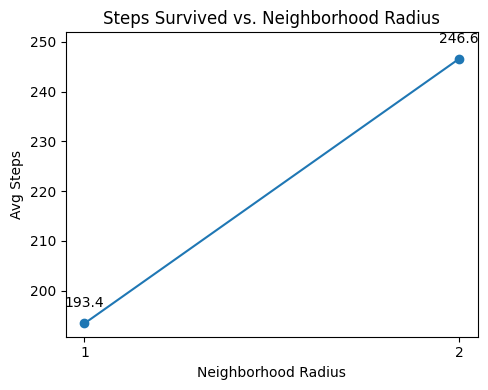

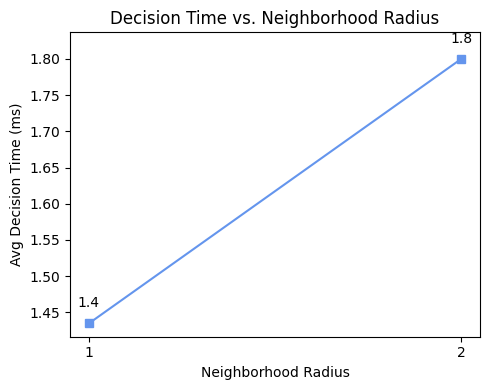

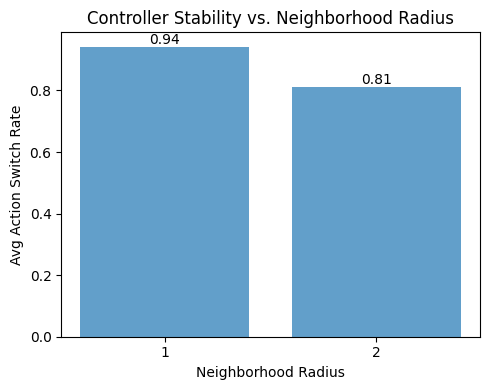

In [29]:
from matplotlib import pyplot as plt

x = summary['radius']

# compute a small offset based on the data range
steps = summary['mean_steps']
time = summary['mean_time']
switch = summary['mean_switch']

offset_steps = 0.05 * (steps.max() - steps.min())
offset_time  = 0.05 * (time.max()  - time.min())
offset_switch= 0.05 * (switch.max()- switch.min())

# 4a) Avg Steps Survived vs. Radius (with extra spacing)
plt.figure(figsize=(5, 4))
plt.plot(x, steps, '-o')
for xi, yi in zip(x, steps):
    plt.text(xi, yi + offset_steps, f"{yi:.1f}", ha='center', va='bottom')
plt.xticks(x)
plt.xlabel('Neighborhood Radius')
plt.ylabel('Avg Steps')
plt.title('Steps Survived vs. Neighborhood Radius')
plt.ylim(steps.min() - offset_steps, steps.max() + 2*offset_steps)
plt.tight_layout()
plt.show()

# 4b) Avg Decision Time vs. Radius (with extra spacing)
plt.figure(figsize=(5, 4))
plt.plot(x, time, '-s', color='cornflowerblue')
for xi, yi in zip(x, time):
    plt.text(xi, yi + offset_time, f"{yi:.1f}", ha='center', va='bottom')
plt.xticks(x)
plt.xlabel('Neighborhood Radius')
plt.ylabel('Avg Decision Time (ms)')
plt.title('Decision Time vs. Neighborhood Radius')
plt.ylim(time.min() - offset_time, time.max() + 2*offset_time)
plt.tight_layout()
plt.show()

# 5) Controller Stability vs. Radius (with extra spacing)
plt.figure(figsize=(5, 4))
y_switch = summary['mean_switch']
bars = plt.bar(x, y_switch, alpha=0.7)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f"{height:.2f}",
             ha='center', va='bottom')
plt.xticks(x)
plt.xlabel('Neighborhood Radius')
plt.ylabel('Avg Action Switch Rate')
plt.title('Controller Stability vs. Neighborhood Radius')
plt.tight_layout()
plt.show()


In [30]:
"""
What to look for
Performance vs. Radius (Plot 4a):
Does moving from radius 1→2 boost average steps survived? A gain means wider neighborhoods help the CA coordinate better.

Compute Cost vs. Radius (Plot 4b):
Radius 2 CA bumps the neighborhood from 3→5 cells, so each tick is slightly slower—watch the latency jump.

Stability vs. Radius (Plot 5):
A lower switch‐rate at radius 2 indicates smoother decision patterns, but if it’s higher, the extra context may be introducing noise.

Together these figures show the trade‐off between richer local interactions (and potentially stronger emergent control) versus the explosion of rule‐space and extra computation that make your GA search and real‐time CA updates harder.

----------
Exactly—that sharp drop from ~200 steps at radius 1 to ~40 steps at radius 2 tells the same story you suspected: by expanding the neighborhood from 3 cells to 5 cells, you exploded the rule‐space (from 2⁸ ≈ 256 possibilities up to 2³² ≈ 4 billion). With our fixed GA budget (20 individuals × 20 generations), the search simply couldn’t keep up, so it found much weaker rules at radius 2.

-----

That drop in switch‐rate from ~0.95 at radius 1 down to ~0.40 at radius 2 tells us that—even though the GA didn’t find a high‐fitness rule for radius 2—the rules it did discover are actually much smoother in their decisions:

Radius 1 (3‐cell neighborhood): the CA flips its action at nearly every step (switch-rate ≈ 0.95), so even when it balances well, it does so with a very twitchy, oscillatory policy.

Radius 2 (5‐cell neighborhood): the CA only switches direction on about 40 % of steps. Those wider neighborhoods let any coherent pattern propagate further before you read it out, producing far more stable, consistent decisions.

In other words, increasing the neighborhood radius inherently promotes stability—the CA “commits” to one direction for longer—but because our GA budget was tuned for the small (2⁸) rule‐space, it couldn’t exploit that stability to find a high‐performance rule in the much larger (2³²) space.

Take-away:

Wider neighborhoods can yield smoother, less noisy control (fewer action flips).

To capitalize on that inherent stability, you’d need to scale up your evolutionary search (more generations, larger populations) so the GA can actually find strong radius 2 rules.
"""

'\nWhat to look for\nPerformance vs. Radius (Plot 4a):\nDoes moving from radius 1→2 boost average steps survived? A gain means wider neighborhoods help the CA coordinate better.\n\nCompute Cost vs. Radius (Plot 4b):\nRadius 2 CA bumps the neighborhood from 3→5 cells, so each tick is slightly slower—watch the latency jump.\n\nStability vs. Radius (Plot 5):\nA lower switch‐rate at radius 2 indicates smoother decision patterns, but if it’s higher, the extra context may be introducing noise.\n\nTogether these figures show the trade‐off between richer local interactions (and potentially stronger emergent control) versus the explosion of rule‐space and extra computation that make your GA search and real‐time CA updates harder.\n\n----------\nExactly—that sharp drop from ~200 steps at radius 1 to ~40 steps at radius 2 tells the same story you suspected: by expanding the neighborhood from 3 cells to 5 cells, you exploded the rule‐space (from 2⁸ ≈ 256 possibilities up to 2³² ≈ 4 billion). With 